<a href="https://colab.research.google.com/github/psriraj17/ML_AirplaneParts/blob/main/airplaneparts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning model for Components to predict the Machine run-time hours and Debur hours.



This notebook is developed to implement Machine Learning models onto a real-time dataset to predict the Machining time and Debur time for a particular component which varies with the dimensions of the material and number of jobs required. The dataset you see in this notebook is acquired from Domaille Companies, few attributes/variables were modified for privacy reasons accordingly.

There are two phases for the manufacturing – machining (actually cutting the material) and then deburr (cleaning up the cut material).
Here is what the target variables actually mean.

Machining times:

Primary – Tmp (hrs): template hours (roughly “how long does the computer say this job should take?”)

Primary – Est (hrs): estimated hours, should match Tmp

Primary – Act (hrs): the actual hours averaged for the last three times the job ran

Deburr times:

Deburr – Tmp (hrs): template hours

Deburr – Est (hrs): estimated hours, should largely match Tmp

Deburr – Act (hrs): the actual hours averaged for the last three times the job ran

These target variables are predicted wrt some of the features like, material type, material form, dimensions of the material for particular job and etc. 

The predictions are made using two Non-linear Regression models i.e., KNNRegressor (sci-kit learn) where we consider only the Numerical data of the dataset to predict. Likewise, XGBRegressor (XGBoost) where we consider both the numerical and categorical data for predictions.

The Metric for evaluation is average hours difference the model is predicting that the job can be done, along with this we are also determining the model performance using model.score, to check if co-relation exists between the features and labels.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'MyDrive'

Mounted at /content/drive
/content/drive/MyDrive


Importing all the required packages for implementation.

In [3]:
import pandas as pd  
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

# Data Loading

Data is read from the file and checked if there exists NaN" values and eliminated if found.

In [4]:

Data =  pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Airplane Parts/Material Size with Hours - Cleansed 20221112.xlsx', header=0)#, quoting = csv.QUOTE_NONE
Data= Data[:-1]
Data = Data.dropna(axis=0)


In [5]:
Data

,Item,Class,Sector,Platform Label,Mtl_Type,Mtl_Form,Mtl_Thick (in),Mtl_Width (in),Mtl_Length (in),Mtl_Makes,Mtl_Axes,Primary - Tmp (hrs),Primary - Est (hrs),Primary - Act (hrs),Deburr - Tmp (hrs),Deburr - Est (hrs),Deburr - Act (hrs)
0,2,5AXLS,Com,22.0,Al_x000D_\n,PL_x000D_\n,2.75,25.00,42.00,2.0,5.0,4.000000,4.000000,5.241667,1.00,1.000000,1.911667
1,3,5AXLS,Com,22.0,Al_x000D_\n,PL_x000D_\n,2.00,11.88,18.00,1.0,5.0,4.000000,4.000000,3.005000,0.50,0.500000,1.038333
2,4,5AXLS,Com,22.0,Al_x000D_\n,PL_x000D_\n,2.75,25.00,42.00,2.0,5.0,4.000000,4.000000,5.177500,0.50,0.500000,1.993333
3,5,5AXLS,Com,22.0,Al_x000D_\n,PL_x000D_\n,2.00,11.88,18.00,1.0,5.0,4.000000,4.000000,2.987500,0.50,0.500000,0.976667
4,6,SNKHS,Mil,6.0,Ti_x000D_\n,EX_x000D_\n,2.00,5.25,68.50,1.0,5.0,4.000000,2.666667,2.825556,0.00,0.000000,0.598125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,1106,LATHE,Mil,19.0,CA_x000D_\n,BR_x000D_\n,4.00,2.00,2.00,1.0,5.0,0.425000,0.482000,0.472718,0.17,0.170000,0.128632
683,1107,SNKHS,Mil,19.0,Al_x000D_\n,PL_x000D_\n,1.25,32.00,46.25,1.0,3.0,5.230000,5.230000,10.074167,2.67,2.670000,1.502000
686,1112,MAG1,MIL,17.0,Al_x000D_\n,PL_x000D_\n,2.75,11.75,40.00,1.0,5.0,1.783333,1.783333,6.967222,1.47,1.470000,2.071667
687,1114,MAG1,Mil,17.0,Al_x000D_\n,PL_x000D_\n,3.00,13.00,39.50,1.0,0.0,1.460000,1.460000,4.531667,1.35,1.350000,2.527500


Creating a different dataset for numerical data.

In [6]:
numerical_data = Data[['Platform Label','Mtl_Thick (in)','Mtl_Width (in)','Mtl_Length (in)','Mtl_Makes','Mtl_Axes']]

In [7]:
numerical_data

,Platform Label,Mtl_Thick (in),Mtl_Width (in),Mtl_Length (in),Mtl_Makes,Mtl_Axes
0,22.0,2.75,25.00,42.00,2.0,5.0
1,22.0,2.00,11.88,18.00,1.0,5.0
2,22.0,2.75,25.00,42.00,2.0,5.0
3,22.0,2.00,11.88,18.00,1.0,5.0
4,6.0,2.00,5.25,68.50,1.0,5.0
...,...,...,...,...,...,...
682,19.0,4.00,2.00,2.00,1.0,5.0
683,19.0,1.25,32.00,46.25,1.0,3.0
686,17.0,2.75,11.75,40.00,1.0,5.0
687,17.0,3.00,13.00,39.50,1.0,0.0


# Primary Template/Estimated hours Prediction

We create a function to pass in our numerical data and target. The data is split into training (80% for model development) and testing (20% for new data prediction). The trainig this passed into model for fitting and then the model is used for predictions. 
Based on the prediction and with our actual test data we determine the average hours below. 

In [8]:
from sklearn.utils.fixes import sklearn
def predict_primaryTemp(numerical_data, target):
  #Data Spliting using train_test_split (sklearn)
  num_train, num_test, primTemp_train, primTemp_test = train_test_split(numerical_data, target,test_size=0.2, random_state=42)
  #model 
  KNN = KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree')
  #fitting the training data into model
  KNN.fit(num_train, primTemp_train)
  #model performance 
  score = KNN.score(num_test, primTemp_test)
  #New Predictions 
  predictions = KNN.predict(num_test)
  #Average hours 
  avg_hrs =  np.sum(np.abs(predictions - primTemp_test))/len(primTemp_test)
  

  return avg_hrs, score, predictions, primTemp_test

In [9]:
primTemp_avg_hrs , primTemp_score, primTemp_pred , primTemp_test = predict_primaryTemp(numerical_data, Data['Primary - Tmp (hrs)'])
print("Model Performance Score:", primTemp_score)
print("Average Hours:", primTemp_avg_hrs)

Model Performance Score: 0.7463238848067469
Average Hours: 0.9968786666666667


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately one hour. 

# Primary Actual hours prediction considering only Numerical Data

In [10]:
from sklearn.utils.fixes import sklearn
def predict_primaryAct(numerical_data, target):
  # Data Spliting
  num_train, num_test, primAct_train, primAct_test = train_test_split(numerical_data, target, test_size=0.2, random_state=42)
  #model
  KNN = KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree')
  #fitting the training data into model
  KNN.fit(num_train, primAct_train)
  #Model performance
  score = KNN.score(num_test, primAct_test)
  #preditind new data
  predictions = KNN.predict(num_test)
  #Average hours
  avg_hrs =  np.sum(np.abs(predictions - primAct_test))/len(primAct_test)

  return avg_hrs, score

In [11]:
primAct_avg_hrs, primAct_score = predict_primaryAct(numerical_data, Data['Primary - Act (hrs)'])
print("Model Performance Score:", primAct_score)
print("Average Hours:", primAct_avg_hrs)

Model Performance Score: 0.77921164191843
Average Hours: 1.3031461593046647


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 1.3 hours

# Debur Template/Estimated hours prediction using only numerical data

In [12]:
def predict_DeburTemp(numerical_data, target):

  DeburTemp_train, DeburTemp_test, target_train, target_test = train_test_split(numerical_data, target, test_size=0.2, random_state=42)

  KNN = KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree')
  
  KNN.fit(DeburTemp_train, target_train)

  score = KNN.score(DeburTemp_test, target_test)

  pred = KNN.predict(DeburTemp_test)
  avg_hrs =  np.sum(np.abs(pred - target_test))/len(target_test)

  return avg_hrs, score


In [13]:
Deburtemp_avg_hrs, DeburTemp_score = predict_DeburTemp(numerical_data, Data['Deburr - Tmp (hrs)'])
print("Model Performance Score:",DeburTemp_score)
print("Average Hours:", Deburtemp_avg_hrs)

Model Performance Score: 0.5883572982901886
Average Hours: 0.46010666666666666


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 0.46 hours

# Debur Actual hours prediction using only numerical data

In [14]:
from sklearn.utils.fixes import sklearn
def predict_DeburAct(numerical_data, target):

  DeburAct_train, DeburAct_test, target_train, target_test = train_test_split(numerical_data, target, test_size=0.2, random_state=42)

  KNN = KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree')
  KNN.fit(DeburAct_train, target_train)

  score = KNN.score(DeburAct_test, target_test)
  pred = KNN.predict(DeburAct_test)
  avg_hrs =  np.sum(np.abs(pred - target_test))/len(target_test)
  
  return avg_hrs, score

In [15]:
DeburAct_avg_hrs, DeburAct_score = predict_DeburAct(numerical_data, Data['Deburr - Act (hrs)'])
print("Model Performance Score:",DeburAct_score)
print("Average Hours:", DeburAct_avg_hrs)

Model Performance Score: 0.5140543801515485
Average Hours: 0.5793808334241463


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 0.57 hours

# Combined Template/Estimated hours prediction using only numerical data

Here, we combine the Primary template and Debur template hours to predict the total time taken for a job to be completed.

In [16]:
combinedTemp = Data['Deburr - Tmp (hrs)'] + Data['Primary - Tmp (hrs)']

In [17]:
from sklearn.utils.fixes import sklearn
def predict_combinedTemp(numerical_data, target):

  num_train, num_test, combinedTemp_train, combinedTemp_test = train_test_split(numerical_data, target, test_size=0.2, random_state=42)

  KNN = KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree')
  KNN.fit(num_train, combinedTemp_train)

  score = KNN.score(num_test, combinedTemp_test)
  
  pred = KNN.predict(num_test)
  avg_hrs =  np.sum(np.abs(pred - combinedTemp_test))/len(combinedTemp_test)
  
  return avg_hrs, score, pred, combinedTemp_test

In [18]:
combinedTemp_avg_hrs, combinedTemp_score, combinedTemp_pred, combinedTemp_test = predict_combinedTemp(numerical_data, combinedTemp)
print("Model Performance Score:", combinedTemp_score)
print("Average Hours:", combinedTemp_avg_hrs)

Model Performance Score: 0.7269946515505437
Average Hours: 1.3799986666666666


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 1.38 hours. 

# Combined Actual hours prediction using only numerical data

Again, we combine both Primary Actual and Debur Actual hours as target variable over numerical feature values.

In [19]:
combinedAct = Data['Primary - Act (hrs)'] + Data['Deburr - Act (hrs)']

In [20]:
from sklearn.utils.fixes import sklearn
def predict_combinedAct(numerical_data, target):

  num_train, num_test, combinedAct_train, combinedAct_test = train_test_split(numerical_data, target, test_size=0.2, random_state=42)

  KNN = KNeighborsRegressor(n_neighbors=2, algorithm='ball_tree')
  KNN.fit(num_train, combinedAct_train)

  score = KNN.score(num_test, combinedAct_test)

  pred = KNN.predict(num_test)
  avg_hrs =  np.sum(np.abs(pred - combinedAct_test))/len(combinedAct_test)

  return avg_hrs, score, pred, combinedAct_test

In [21]:
combinedAct_avg_hrs, combinedAct_score, combinedAct_pred, combinedAct_test = predict_combinedAct(numerical_data, combinedAct)
print("Model Performance Score:", combinedAct_score)
print("Average Hours:",combinedAct_avg_hrs)

Model Performance Score: 0.795512186033331
Average Hours: 1.5398386390431982


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 1.54 hours. 

# Predictions based on XGBoost 

Now, the idea is to consider both numerical and categorical data for the prediction and we considered XGBRegressor model.

In [22]:
Data

,Item,Class,Sector,Platform Label,Mtl_Type,Mtl_Form,Mtl_Thick (in),Mtl_Width (in),Mtl_Length (in),Mtl_Makes,Mtl_Axes,Primary - Tmp (hrs),Primary - Est (hrs),Primary - Act (hrs),Deburr - Tmp (hrs),Deburr - Est (hrs),Deburr - Act (hrs)
0,2,5AXLS,Com,22.0,Al_x000D_\n,PL_x000D_\n,2.75,25.00,42.00,2.0,5.0,4.000000,4.000000,5.241667,1.00,1.000000,1.911667
1,3,5AXLS,Com,22.0,Al_x000D_\n,PL_x000D_\n,2.00,11.88,18.00,1.0,5.0,4.000000,4.000000,3.005000,0.50,0.500000,1.038333
2,4,5AXLS,Com,22.0,Al_x000D_\n,PL_x000D_\n,2.75,25.00,42.00,2.0,5.0,4.000000,4.000000,5.177500,0.50,0.500000,1.993333
3,5,5AXLS,Com,22.0,Al_x000D_\n,PL_x000D_\n,2.00,11.88,18.00,1.0,5.0,4.000000,4.000000,2.987500,0.50,0.500000,0.976667
4,6,SNKHS,Mil,6.0,Ti_x000D_\n,EX_x000D_\n,2.00,5.25,68.50,1.0,5.0,4.000000,2.666667,2.825556,0.00,0.000000,0.598125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,1106,LATHE,Mil,19.0,CA_x000D_\n,BR_x000D_\n,4.00,2.00,2.00,1.0,5.0,0.425000,0.482000,0.472718,0.17,0.170000,0.128632
683,1107,SNKHS,Mil,19.0,Al_x000D_\n,PL_x000D_\n,1.25,32.00,46.25,1.0,3.0,5.230000,5.230000,10.074167,2.67,2.670000,1.502000
686,1112,MAG1,MIL,17.0,Al_x000D_\n,PL_x000D_\n,2.75,11.75,40.00,1.0,5.0,1.783333,1.783333,6.967222,1.47,1.470000,2.071667
687,1114,MAG1,Mil,17.0,Al_x000D_\n,PL_x000D_\n,3.00,13.00,39.50,1.0,0.0,1.460000,1.460000,4.531667,1.35,1.350000,2.527500


Data factorization

In order for us to consider categorical values into the dataset, we cannot proceed with its original values rather they should be converted into numerical valaues or create dummies, so we factorize the varaibles using pandas.

In [23]:
Data['Mtl_Type'] = pd.factorize(Data['Mtl_Type'])[0]
Data['Mtl_Form'] = pd.factorize(Data['Mtl_Form'])[0]
Data['Class'] = pd.factorize(Data['Class'])[0]
Data['Sector'] = pd.factorize(Data['Sector'])[0]

In [24]:
Data

,Item,Class,Sector,Platform Label,Mtl_Type,Mtl_Form,Mtl_Thick (in),Mtl_Width (in),Mtl_Length (in),Mtl_Makes,Mtl_Axes,Primary - Tmp (hrs),Primary - Est (hrs),Primary - Act (hrs),Deburr - Tmp (hrs),Deburr - Est (hrs),Deburr - Act (hrs)
0,2,0,0,22.0,0,0,2.75,25.00,42.00,2.0,5.0,4.000000,4.000000,5.241667,1.00,1.000000,1.911667
1,3,0,0,22.0,0,0,2.00,11.88,18.00,1.0,5.0,4.000000,4.000000,3.005000,0.50,0.500000,1.038333
2,4,0,0,22.0,0,0,2.75,25.00,42.00,2.0,5.0,4.000000,4.000000,5.177500,0.50,0.500000,1.993333
3,5,0,0,22.0,0,0,2.00,11.88,18.00,1.0,5.0,4.000000,4.000000,2.987500,0.50,0.500000,0.976667
4,6,1,1,6.0,1,1,2.00,5.25,68.50,1.0,5.0,4.000000,2.666667,2.825556,0.00,0.000000,0.598125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,1106,7,1,19.0,8,7,4.00,2.00,2.00,1.0,5.0,0.425000,0.482000,0.472718,0.17,0.170000,0.128632
683,1107,1,1,19.0,0,0,1.25,32.00,46.25,1.0,3.0,5.230000,5.230000,10.074167,2.67,2.670000,1.502000
686,1112,2,2,17.0,0,0,2.75,11.75,40.00,1.0,5.0,1.783333,1.783333,6.967222,1.47,1.470000,2.071667
687,1114,2,1,17.0,0,0,3.00,13.00,39.50,1.0,0.0,1.460000,1.460000,4.531667,1.35,1.350000,2.527500


Dataset for features

In [25]:
NumCat_data = Data[['Class',	'Sector',	'Platform Label',	'Mtl_Type',	'Mtl_Form',	'Mtl_Thick (in)',	'Mtl_Width (in)',	'Mtl_Length (in)',	'Mtl_Makes'	,'Mtl_Axes']]

# Primary Template hours prediction

The model is implemented considering few hyperparameters such learning rate, max_depth and n_estimators. These parameters are tuned to achieve the best model performance.

In [26]:
def xgPrimTemp(x, y):

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  model = XGBRegressor(learning_rate=0.05,max_depth=2,n_estimators=5000).fit(x,y)

  predictions = model.predict(x_test)
  print(f"Mean squared error: {mean_squared_error(y_test, predictions)}")
  avg_hrs =  np.sum(np.abs(predictions - y_test))/len(y_test)
  score = model.score(x_test, y_test)

  return avg_hrs, score


In [27]:
xgPrimTemp_avg_hrs, xgPrimTemp_score = xgPrimTemp(NumCat_data,  Data['Primary - Tmp (hrs)'])
print("Model Performance Score:", xgPrimTemp_score)
print("Average Hours:",xgPrimTemp_avg_hrs)

[20:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.09388966802223529
Model Performance Score: 0.9959629619997419
Average Hours: 0.18170358762995403


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 0.18 hours.

# Primary Actual hours prediction

In [49]:
def xgPrimAct(x, y):

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  model = XGBRegressor(learning_rate=0.05,max_depth=2,n_estimators=5000).fit(x,y)

  predictions = model.predict(x_test)
  print(f"Mean squared error: {mean_squared_error(y_test, predictions)}")
  avg_hrs =  np.sum(np.abs(predictions - y_test))/len(y_test)
  score = model.score(x_test, y_test)

  return avg_hrs, score


In [50]:
xgPrimAct_avg_hrs, xgPrimAct_score = xgPrimAct(NumCat_data,  Data['Primary - Act (hrs)'])
print("Model Performance Score:", xgPrimAct_score)
print("Average Hours:",xgPrimAct_avg_hrs)

[20:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.4358640131266626
Model Performance Score: 0.981593589399758
Average Hours: 0.3822330272097643


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 0.38 hours.

# Debur Template hours prediction

In [51]:
def xgDeburTemp(x, y):

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  model = XGBRegressor(learning_rate=0.05,max_depth=2,n_estimators=5000).fit(x,y)

  predictions = model.predict(x_test)
  print(f"Mean squared error: {mean_squared_error(y_test, predictions)}")
  avg_hrs =  np.sum(np.abs(predictions - y_test))/len(y_test)
  score = model.score(x_test, y_test)

  return avg_hrs, score


In [52]:
xgDeburTemp_avg_hrs, xgDeburTemp_score = xgDeburTemp(NumCat_data,  Data['Deburr - Tmp (hrs)'])
print("Model Performance Score:", xgDeburTemp_score)
print("Average Hours:",xgDeburTemp_avg_hrs)

[20:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.037355842075429156
Model Performance Score: 0.9832208480651928
Average Hours: 0.09679567767143249


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 0.096 hours.

# Debur Actual hours prediction

In [54]:
def xgDeburAct(x, y):

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  model = XGBRegressor(learning_rate=0.05,max_depth=2,n_estimators=5000).fit(x,y)

  predictions = model.predict(x_test)
  print(f"Mean squared error: {mean_squared_error(y_test, predictions)}")
  avg_hrs =  np.sum(np.abs(predictions - y_test))/len(y_test)
  score = model.score(x_test, y_test)

  return avg_hrs, score


In [55]:
xgDeburAct_avg_hrs, xgDeburAct_score = xgDeburAct(NumCat_data,  Data['Deburr - Act (hrs)'])
print("Model Performance Score:", xgDeburAct_score)
print("Average Hours:",xgDeburAct_avg_hrs)

[20:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.13367565892473887
Model Performance Score: 0.9316362180818856
Average Hours: 0.21883775655908116


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 0.22 hours.

# Combined Template hours prediction

Here we consider both Primary Template and Debur Template combined as target variable.

In [56]:
def xgCombinedTemp(x, y):

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  model = XGBRegressor(learning_rate=0.05,max_depth=2,n_estimators=5000).fit(x,y)

  predictions = model.predict(x_test)
  print(f"Mean squared error: {mean_squared_error(y_test, predictions)}")
  avg_hrs =  np.sum(np.abs(predictions - y_test))/len(y_test)
  score = model.score(x_test, y_test)

  return avg_hrs, score,predictions, y_test

In [57]:
xgCombinedTemp_avg_hrs, xgCombinedTemp_score, xgCombinedTemp_pred, xgCombinedTemp_test =  xgCombinedTemp(NumCat_data,  combinedTemp)
print("Model Performance Score:", xgCombinedTemp_score)
print("Average Hours:",xgCombinedTemp_avg_hrs)

[20:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.1521391096629296
Model Performance Score: 0.9953748415269059
Average Hours: 0.23270061553255716


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 0.23 hours.

# Combined Actual hours prediction

In [58]:
def xgCombinedAct(x, y):

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  model = XGBRegressor(learning_rate=0.05,max_depth=2,n_estimators=5000).fit(x,y)

  predictions = model.predict(x_test)
  print(f"Mean squared error: {mean_squared_error(y_test, predictions)}")
  avg_hrs =  np.sum(np.abs(predictions - y_test))/len(y_test)
  score = model.score(x_test, y_test)

  return avg_hrs, score,predictions, y_test

In [59]:
xgCombinedAct_avg_hrs, xgCombinedAct_score, xgCombinedAct_pred, xgCombinedAct_test = xgCombinedAct(NumCat_data,  combinedAct)
print("Model Performance Score:", xgCombinedAct_score)
print("Average Hours:",xgCombinedAct_avg_hrs)

[20:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.6080662048341922
Model Performance Score: 0.9826686009776519
Average Hours: 0.47238435478191343


From the above "Average Hours" value we can see that, on an average the model is predicting that the job can be done as per the time quoted with a difference of approximately 0.47 hours.

# Visualizing the predictions over scatter plot

**Combined Template hours prediction considering only numerical data (PLOT-1)**

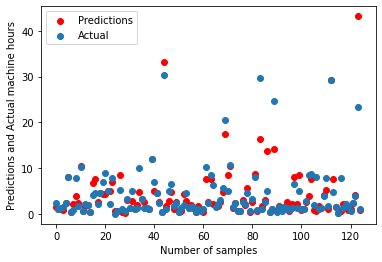

In [40]:
x_values = range(0,len(primTemp_test))
plt.scatter(x_values , combinedTemp_pred, c= "r", label= "Predictions")
plt.scatter(x_values, combinedTemp_test,label= "Actual")

plt.xlabel("Number of samples")
plt.ylabel("Predictions and Actual machine hours")
plt.legend()
plt.show()

From the graph we can visualize the actual test values over the model prediction 

**Combined Actual hours prediction considering only numerical data(PLOT-2)**

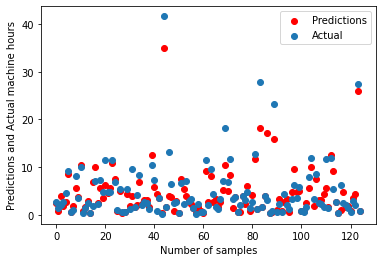

In [41]:
x_values = range(0,len(primTemp_test))
plt.scatter(x_values , combinedAct_pred, c= "r", label= "Predictions")
plt.scatter(x_values, combinedAct_test,label= "Actual")

plt.xlabel("Number of samples")
plt.ylabel("Predictions and Actual machine hours")
plt.legend()
plt.show()


**Combined Template hours prediction using both numerical and categorical data(PLOT-3)**

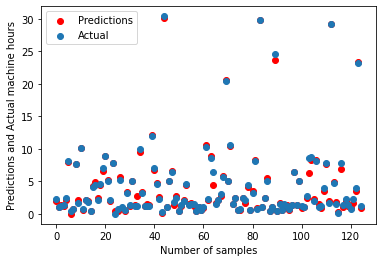

In [42]:
x_values = range(0,len(primTemp_test))
plt.scatter(x_values , xgCombinedTemp_pred, c= "r", label= "Predictions")
plt.scatter(x_values, xgCombinedTemp_test,label= "Actual")

plt.xlabel("Number of samples")
plt.ylabel("Predictions and Actual machine hours")
plt.legend()
plt.show()

upon comparing plot 1 and plot 3 we can notice that the model is predicting almost as the actual values due to the learning and adjusting the hyparameters

**Combined Actual hours considering both numerical and categorical data(PLOT-4)**

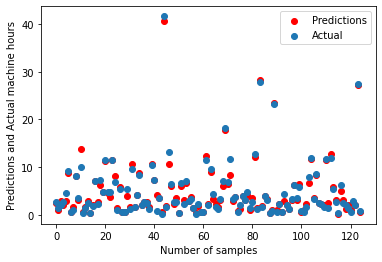

In [43]:
x_values = range(0,len(primTemp_test))
plt.scatter(x_values , xgCombinedAct_pred, c= "r", label= "Predictions")
plt.scatter(x_values, xgCombinedAct_test,label= "Actual")

plt.xlabel("Number of samples")
plt.ylabel("Predictions and Actual machine hours")
plt.legend()
plt.show()

Visualizing the outputs of the models considering numerical data only.

In [44]:
DataFrame = [['Primary Template/ Estimates',primTemp_avg_hrs, primTemp_score],['Primary Actual', primAct_avg_hrs, primAct_score],['Debur Template/Estimated', Deburtemp_avg_hrs, DeburTemp_score],
             ['Debur Actual', DeburAct_avg_hrs, DeburAct_avg_hrs],['Primary+Debur Template', combinedTemp_avg_hrs, combinedTemp_score],['Primary+Debur Actual',combinedAct_avg_hrs, combinedAct_score]]


df = pd.DataFrame(DataFrame, columns=[' ', 'Average Hours','Co-relation Score'])

In [45]:
df

,,Average Hours,Co-relation Score
0,Primary Template/ Estimates,0.996879,0.746324
1,Primary Actual,1.303146,0.779212
2,Debur Template/Estimated,0.460107,0.588357
3,Debur Actual,0.579381,0.579381
4,Primary+Debur Template,1.379999,0.726995
5,Primary+Debur Actual,1.539839,0.795512


Visualizing the outputs of the model considering numerical and categorical data.

In [46]:
DataFrame1 = [['Primary Template/ Estimates ',xgPrimTemp_avg_hrs, xgPrimTemp_score],['Primary Actual', xgPrimAct_avg_hrs, xgPrimAct_score],['Debur Template/Estimated', xgDeburTemp_avg_hrs, xgDeburTemp_score],
             ['Debur Actual', xgDeburAct_avg_hrs, xgDeburAct_score],['Primary+Debur Template', xgCombinedTemp_avg_hrs, xgCombinedTemp_score],['Primary+Debur Actual',xgCombinedAct_avg_hrs, xgCombinedAct_score]]


df = pd.DataFrame(DataFrame1, columns=['(numerical and categorical with parameter tuning) ', 'Average Hours','Co-relation Score'])

In [47]:
df

,(numerical and categorical with parameter tuning),Average Hours,Co-relation Score
0,Primary Template/ Estimates,0.181704,0.995963
1,Primary Actual,0.382233,0.981594
2,Debur Template/Estimated,0.096796,0.983221
3,Debur Actual,0.218838,0.931636
4,Primary+Debur Template,0.232701,0.995375
5,Primary+Debur Actual,0.472384,0.982669
